In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle
from ssm.stats import multivariate_normal_logpdf
from ssm.primitives import hmm_expected_states, hmm_sample
from pylds.lds_messages_interface import info_E_step


In [2]:
D = 8
K = 16
nlags = 3

data = np.load('arhmm_decoding_data.npz')
neural = data['neural']
xs = data['latents']
zs = data['states']

In [3]:
# Have to lag the neural activity for each batch

W = 8
N = neural[0].shape[1]

ns_window = [_ for i in range(len(neural))]
for i in range(len(neural)):
    T = neural[i].shape[0]
    neural_pad = np.concatenate([np.zeros((W//2, N)), neural[i], np.zeros((W//2, N))])
    ns_window[i] = np.column_stack([neural_pad[w:T+w] for w in range(W)] )

# Have to lag the latents for each batch 
W = nlags
xs_eff = [_ for i in range(len(xs))]
for i in range(len(neural)):
    xs_pad = np.concatenate([np.zeros((W-1,D)), xs[i]])
    xs_eff[i] = np.column_stack([xs_pad[w:T+w] for w in reversed(range(W))])



In [4]:
# Concatente into sequences, take only part for now
T=10000
ns_window_flat =np.concatenate(ns_window,axis=0)[:T]
zs_flat = np.concatenate(zs,axis=0)[:T]
xs_eff_flat = np.concatenate(xs_eff,axis=0)[:T]

In [5]:
# Logistic regression

recog_z = LogisticRegression(solver='lbfgs', max_iter=500)
recog_z.fit(ns_window_flat, zs_flat)


/Users/eleanorbatty/anaconda/envs/behavenet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/eleanorbatty/anaconda/envs/behavenet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/eleanorbatty/anaconda/envs/behavenet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/eleanorbatty/anaconda/envs/behavenet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/eleanorbatty/anaconda/envs/beh

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [6]:
# Linear regression

recog_x = LinearRegression()
recog_x.fit(ns_window_flat, xs_eff_flat)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
# Load in ARHMM model and get parameters

arhmm_model = pickle.load(open('best_val_model.pt','rb'))

P = arhmm_model.transitions.transition_matrix
As = arhmm_model.observations.As
bs = arhmm_model.observations.bs
Qs = arhmm_model.observations.Sigmas

evals, evecs = np.linalg.eig(P.T)
perm = np.argsort(evals)[::-1]
evals, evecs = evals[perm], evecs[:, perm]
assert np.allclose(evals[0], 1.0)
if np.any(evecs[:,0] <= 0):
    evecs[:,0] = -1*evecs[:,0]
assert np.all(evecs[:,0] >= 0) 
pz_infty = np.real(evecs[:, 0] / evecs[:, 0].sum())

mu_infty = np.zeros((K, D*nlags))
Sigma_infty = np.zeros((K, D*nlags, D*nlags))
for k in range(K):
    mu_infty[k,:D] = np.mean(xs_eff_flat[zs_flat == k,:D],axis=0)
    #Sigma_infty[k] = np.cov(training_ae[training_arhmm == k].T)
    Sigma_infty[k,:D,:D] = np.cov(xs_eff_flat[:,:D].T)
    for l in range(1, nlags):
        Sigma_infty[k, l*D:(l+1)*D, l*D:(l+1)*D] = np.eye(D)
 
# mu_infty = np.zeros((K, D*nlags))
# Sigma_infty = np.zeros((K, D*nlags, D*nlags))
# for k in range(K):
#     mu_infty[k] = np.mean(xs_eff_flat[zs_flat == k],axis=0)
#     #Sigma_infty[k] = np.cov(training_ae[training_arhmm == k].T)
#     Sigma_infty[k] = np.cov(xs_eff_flat.T)
    
mu0 = np.zeros(D)
Sigma0 = np.eye(D)

In [19]:
# Make effective AR matrices

# Make the big A matrix
As_eff = np.zeros((K, D * nlags, D * nlags))
for k in range(K):
    for l in range(nlags):
        As_eff[k, :D, D*l:D*(l+1)] = As[k, :, l*D:(l+1)*D]
        if l < nlags - 1:
            As_eff[k, (l+1)*D:(l+2)*D, l*D:(l+1)*D] = np.eye(D)
#     U, S, V = np.linalg.svd(As_eff[k])
#     S_clip = np.clip(S, 0, 1-1e-4)
#     As_eff[k] = np.dot(U*S_clip,V)
    
# plt.imshow(big_As[0])
# plt.colorbar()

# Make the big Q (covariance) matrix
Qs_eff = np.zeros((K, D * nlags, D * nlags))
for k in range(K):
    Qs_eff[k, :D, :D] = Qs[k]
    for l in range(1, nlags):
        Qs_eff[k, l*D:(l+1)*D, l*D:(l+1)*D] = 1e-16 * np.eye(D)

bs_eff = np.zeros((K, D * nlags))
for k in range(K):
    bs_eff[k, :D] = bs[k]

# plt.imshow(big_Q[0])
# plt.colorbar()

mu0_eff = np.concatenate((mu0, mu0, mu0))
Sigma0_eff = np.zeros((D*nlags, D*nlags))
for l in range(nlags):
    Sigma0_eff[l*D:(l+1)*D, l*D:(l+1)*D] = Sigma0

In [20]:
# Use the information form.  It will generalize better to VI.
from pylds.lds_messages_interface import info_E_step

# Compute the info potentials for the initial condition
def _info_params(mu0, Sigma0, As, bs, Qs, q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample):
    # parameter checking
    T, K = Ez.shape
    assert As.shape[0] == K and As.ndim == 3 and As.shape[1] == As.shape[2]
    D = As.shape[1]
    assert mu0.shape == (D,)
    assert Sigma0.shape == (D, D)
    assert bs.shape == (K, D)
    assert Qs.shape == (K, D, D)
    assert q_mu_x.shape == (T, D)
    assert q_Sigma_x.shape == (D, D)
    
    # Make pseudo-inputs (all ones) for bias terms
    inputs = np.ones((T, 1))
    
    # Convert initial distribution to info form
    # (ignore normalizing constants)
    J0 = np.linalg.inv(Sigma0)
    h0 = J0 @ mu0
    log_Z0 = 0

    # Info dynamics parameters
    J_pair_22 = np.linalg.inv(Qs)
    J_pair_21 = -np.matmul(np.linalg.inv(Qs), As)
    J_pair_11 = np.matmul(np.swapaxes(As, 1, 2), -J_pair_21)
    mBTQiA = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_21)
    BTQi = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_22)

    # Get expected sufficient statistics by integrating over z
    J_pair_22 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_22)
    J_pair_21 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_21)
    J_pair_11 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_11)
    mBTQiA = np.einsum('tk, kij -> tij', Ez[:-1], mBTQiA)
    BTQi = np.einsum('tk, kij -> tij', Ez[:-1], BTQi)
    h_pair_1 = np.einsum('tu, tud -> td', inputs[:-1], mBTQiA)
    h_pair_2 = np.einsum('tu, tud -> td', inputs[:-1], BTQi)
    log_Z_pair = np.zeros(T-1)

    # Info emission parameters
    J_obs = (np.linalg.inv(q_Sigma_x)+0*np.eye(8*3) - np.linalg.inv(Sigma_infty))[z_sample] #+100*np.eye(8*3)
    h_recog = np.dot(np.linalg.inv(q_Sigma_x)+0*np.eye(8*3), q_mu_x.T).T #np.linalg.solve(q_Sigma_x+10000*np.eye(8*3), q_mu_x.T).T
    h_infty = np.linalg.solve(Sigma_infty, mu_infty)[z_sample]
    h_obs = h_recog + h_infty
    log_Z_obs = np.zeros(T)
    
    return J0, h0, log_Z0, \
           J_pair_11, J_pair_21, J_pair_22, h_pair_1, h_pair_2, log_Z_pair, \
           J_obs, h_obs, log_Z_obs


In [21]:
n_iter = 100
t=150 # which batch to use


# Initialize q(z) with just the learned recognition potential
log_qz = recog_z.predict_log_proba(ns_window[t])
q_mu_x = recog_x.predict(ns_window[t])
q_Sigma_x = np.cov((xs_eff[t] - q_mu_x).T)

z_potential = log_qz - np.log(pz_infty)
Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
z_sample = hmm_sample(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

for i in range(n_iter):
    # compute the expected value of x given z and the observation potential
    _, Ex, _, _ = info_E_step(
        *_info_params(mu0_eff, Sigma0_eff, As_eff, bs_eff, Qs_eff, 
                      q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample)
    )
    
    # Update z, now including the dynamics potential
    # TODO: Should really include the covariance of x in this update too
    z_dyn_potential = np.column_stack(
        [multivariate_normal_logpdf(Ex[1:], Ex[:-1] @ A.T + b, Q) 
         for A, b, Q in zip(As_eff, bs_eff, Qs_eff)])
    z_dyn_potential = np.row_stack((np.zeros(K), z_dyn_potential))
    z_potential = log_qz - np.log(pz_infty) + z_dyn_potential
    Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
    #print(np.unique(Ez))
    print("MSE: ", np.mean((Ex[:,:D] - xs[t])**2))

MSE:  4694736274740.943
MSE:  1714871582364010.2
MSE:  867616837.6281755
MSE:  1531915723977075.8
MSE:  3812069324304.8315
MSE:  3.800874558243795e+19
MSE:  1044274963806.4586
MSE:  5.241213016914264e+18
MSE:  225954669091.5014
MSE:  174726383.2742226
MSE:  87602381838837.81
MSE:  4634677579896330.0
MSE:  1.2797447216859394e+19
MSE:  1689492665587293.5
MSE:  2.322028529347431e+18
MSE:  18603367099.10962
MSE:  13111536699437.084
MSE:  2659739370278.5405
MSE:  9016779405798.992
MSE:  6270313024344.649
MSE:  4.838755037357453e+18
MSE:  1525125018876264.2
MSE:  166751644624414.4
MSE:  361782260507710.6
MSE:  3.3105815165896323e+21
MSE:  6.984499495623912e+20
MSE:  586218065282.8373
MSE:  91068330755.9619
MSE:  22247400632.13402
MSE:  2.6163766499996186e+24
MSE:  4016163747147.433
MSE:  3319160353.0242205
MSE:  27411377.532881964
MSE:  11042646336505.791
MSE:  9363103213918276.0
MSE:  6663367930409.079
MSE:  36889619237.17883
MSE:  1.3421613419392166e+19
MSE:  685027343806106.1
MSE:  141267

In [22]:
np.mean((q_mu_x[:,:D]-xs[t])**2)

0.7090622393421587

In [23]:
np.max(np.abs(np.linalg.eigvals(As_eff)))

1.0421859066348163

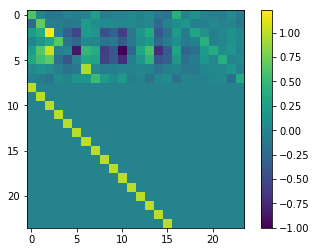

In [24]:
plt.imshow(As_eff[5])
plt.colorbar()

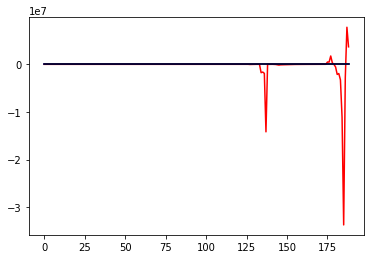

In [25]:
plt.plot(Ex[:,0],'r')
plt.plot(q_mu_x[:,0],'b')
plt.plot(xs[t][:,0],'k')

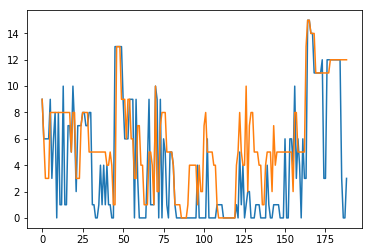

In [15]:
plt.plot(np.argmax(log_qz,axis=1))
plt.plot(zs[t])

In [16]:
len(arhmm_model.observations.params)

4

In [17]:
arhmm_model.observations.Vs

array([], shape=(16, 8, 0), dtype=float64)